<a href="https://colab.research.google.com/github/kunai-3txk/Compe_tonyobyo/blob/main/AMP_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import os
import xgboost as xgb
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error as mape

import lightgbm as lgb #LightGBM
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor,Pool

# Configuration

In [ ]:
class config:
    MAX_PROTEINS = 20
    PROFILE_REPORT = True
    
class paths:
    SAMPLE_SUBMISSION = "/content/drive/MyDrive/AMP/example_test_files/sample_submission.csv"
    SUPPLEMENTAL_CLINICAL_DATA = "/content/drive/MyDrive/AMP/supplemental_clinical_data.csv"
    TRAIN_CLINICAL_DATA = "/content/drive/MyDrive/AMP/train_clinical_data.csv"
    TRAIN_PEPTIDES = "/content/drive/MyDrive/AMP/train_peptides.csv"
    TRAIN_PROTEINS = "/content/drive/MyDrive/AMP/train_proteins.csv"
    TEST_CLINICAL_DATA = "/content/drive/MyDrive/AMP/example_test_files/test.csv"
    TEST_PEPTIDES = "/content/drive/MyDrive/AMP/example_test_files/test_peptides.csv"
    TEST_PROTEINS = "/content/drive/MyDrive/AMP/example_test_files/test_proteins.csv"

# Function Definition

In [ ]:
def display_feature_importance(feature_list,model):

    # 特徴量重要度を保管する dataframe を用意
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = feature_list
    feature_importance['importance'] = model.feature_importances_

    order = list(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:30]
    # 可視化
    plt.figure(figsize=(10, 10))
    sns.barplot(x="importance",y="feature",data=feature_importance,order=order)
    plt.title('importance')
    plt.tight_layout()
    plt.show()

In [ ]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

# Load Data

In [ ]:
train_clinical = pd.read_csv(paths.TRAIN_CLINICAL_DATA)
train_peptides = pd.read_csv(paths.TRAIN_PEPTIDES)
train_proteins = pd.read_csv(paths.TRAIN_PROTEINS)
print('Correct label:Proteins shape: (232741, 5) Peptides shape: (981834, 6) Clinical shape: (2615, 8)')
print('Proteins shape:',train_proteins.shape,'Peptides shape:',train_peptides.shape,'Clinical shape:',train_clinical.shape)

Correct label:Proteins shape: (232741, 5) Peptides shape: (981834, 6) Clinical shape: (2615, 8)
Proteins shape: (232741, 5) Peptides shape: (981834, 6) Clinical shape: (2615, 8)


#Make Train

In [ ]:
train_ProPep = train_peptides.merge(train_proteins[['visit_id','UniProt','NPX']],on=['visit_id','UniProt'],how='left')

In [ ]:
#Make Features
train_clinical['updrs_sum'] = train_clinical['updrs_1']+train_clinical['updrs_2']+train_clinical['updrs_3']+train_clinical['updrs_4']
train_clinical['updrs_sum_expect4'] = train_clinical['updrs_1']+train_clinical['updrs_2']+train_clinical['updrs_3']

In [ ]:
train_ProPep_agg = train_ProPep.groupby('visit_id').mean()
train_all = train_clinical.merge(train_ProPep_agg[['PeptideAbundance','NPX']],on='visit_id',how='left')
print('shape',train_all.shape)
train_all.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0
...,...,...,...,...,...,...,...
645363,21126_36,36,21126,P10909,EILSVDC(UniMod_4)STNNPSQAK,251923.0,8338150.0
645364,21126_36,36,21126,P10909,EIQNAVNGVK,152618.0,8338150.0
645365,21126_36,36,21126,P10909,FM(UniMod_35)ETVAEK,86861.3,8338150.0
645366,21126_36,36,21126,P10909,FMETVAEK,1581860.0,8338150.0


In [ ]:
df_train = train_all[['visit_id','visit_month','updrs_1','updrs_2','updrs_3','updrs_4','PeptideAbundance','NPX']]
df_train.head()
#df_train.info()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,PeptideAbundance,NPX
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,748153.907014,2.028789e+07
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,685218.599872,1.843914e+07
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,740535.423563,2.010976e+07
...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off,NaN,NaN
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off,NaN,NaN
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off,NaN,NaN
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off,NaN,NaN


In [ ]:
#1行だけ欠損を処理
df_train=df_train.dropna(subset=['updrs_1'])

X = df_train.drop(['visit_id','updrs_1'],axis=1).values
y = df_train['updrs_1'].values
train_column_list = df_train.drop(['visit_id','updrs_1'],axis=1).columns

#X = df_train.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1).values
#y = df_train['updrs_{0}'.format(i + 1)].values

# Fit
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

Fold : 1
Fold : 2
Fold : 3
Fold : 4
Fold : 5
fold average score : 56.1260
fold best score : 54.8809  FOLD  1
Test data average score : 53.2922  seed  100
Test data best socre : 53.2580  seed  100


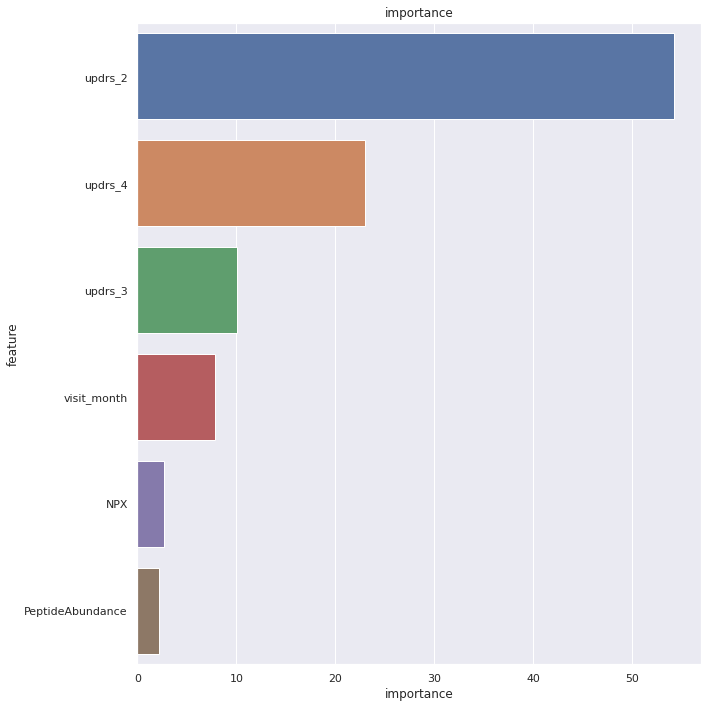

In [ ]:
#固定変数
RANDOM_STATE=100  
FRAC = 0.2
N_FOLD = 5

#****************************************#
# LightGBMの実行 (動作確認レベル)        *
#****************************************#

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=FRAC, random_state=RANDOM_STATE,shuffle=True)


df_log = pd.DataFrame() #Log用DFの定義
models = []                          # 各 fold のモデル
preds = []
scores = 0.0   
best_score = np.inf

kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=RANDOM_STATE)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_train,y_train)):

    X_trn, y_trn = X_train[trn_idx,:], y_train[trn_idx]
    X_val, y_val = X_train[val_idx,:], y_train[val_idx]

    #pool
    train_pool = Pool(X_trn, y_trn)
    validate_pool = Pool(X_val, y_val)

    #with mlflow.start_run(run_name="CatBoost") as run:

    model = CatBoostRegressor(random_seed=RANDOM_STATE,logging_level='Silent',eval_metric = 'SMAPE')
    model.fit(
            train_pool
            ,eval_set = validate_pool    # 検証用データ
            ,early_stopping_rounds = 10  # 10回以上精度が改善しなければ中止
            ,use_best_model=True       # 最も精度が高かったモデルを使用するかの設定
            ,plot=False
            ,verbose=False)                 # 誤差の推移を描画するか否かの設定
    
    # validation データでの予測結果
    val_pred = model.predict(X_val)
    score = smape(y_val,val_pred)
    #print(f"Validation Bagging score : {score:.4f}")

    scores += score / N_FOLD
    models.append(model)

    if score < best_score:
        best_score = score
        best_model = model
        best_fold = fold+1
  

    print("Fold :" , fold+1)

print(f"fold average score : {scores:.4f}")
print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold)
#****************************
# test データ
preds = np.zeros(len(X_test))
# 各モデルで推論
for model in models:
    pred = model.predict(X_test)
    preds += pred / len(models)
    
test_score = smape(y_test, preds)
print(f"Test data average score : {test_score:.4f}"," seed ", RANDOM_STATE)

pred_best = best_model.predict(X_test)
print(f"Test data best socre : {smape(y_test, pred_best):.4f}"," seed ", RANDOM_STATE)

display_feature_importance(train_column_list,best_model)